In [1]:
import sys; sys.path.append('/rds/general/user/cb2714/home/')
from wwa import *

## **Shapefiles**

In [44]:
# load Koppen-Geiger gridded data (& trim down to a more useful size)
kg = xr.open_dataset("kg_classifications.nc").kg_cat.sel(lat = slice(5,60), lon = slice(60,150))

# select India & Bangladesh regions
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(kg.lon, kg.lat).sel(region = [98,99]).sum("region")
rm = rm.where(rm == 1).dropna("lon", "all").dropna("lat", "all")

kg_arr = kg.where(rm == 1)

df = pd.read_csv("kg_legend.csv", index_col = "cat")

rm = kg_arr.where(kg_arr < 4)

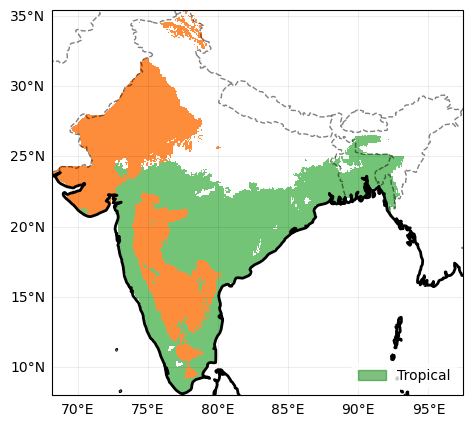

In [68]:
# plot the regions to decide which areas we want to use
fig, ax = plt.subplots(dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (6,5))
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Greens", add_colorbar = False) for r in range(1,4)]
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Oranges", add_colorbar = False) for r in range(4,8)]
# [kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Blues", add_colorbar = False) for r in range(8,16)]
# [kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Purples", add_colorbar = False) for r in range(16,28)]
# [kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Reds", add_colorbar = False) for r in range(28,30)]

ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)    
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

plt.legend(handles = [matplotlib.patches.Patch(color = "green", label = "Tropical", alpha = 0.5)], 
           edgecolor = "w", loc = "lower right")

In [80]:
## CONVERT TO POLYGON
from xrspatial.experimental import polygonize

# define affine transform to correct coordinates
res = list(set(np.diff(kg.lat).round(5)))[0]
transform = np.array([res,0,rm.lon.min().values - res/2,0,res,rm.lat.min().values + res/2])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# convert xarray data to polygon, remove any interior holes
rm_ext = xr.ones_like(kg_arr).where(kg_arr < 4)

rm_poly = polygonize(rm_ext, mask = ~np.isnan(rm_ext), return_type = "geopandas", transform = transform)
rm_poly["geometry"] = rm_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))
rm_poly = rm_poly[rm_poly.geometry.area == rm_poly.geometry.area.max()]
rm_poly = rm_poly.simplify(res)

rm_poly.set_crs(epsg = 4326).to_file("sf_indiabangladesh-tropical-exterior")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# polygon of semi-arid region
rm_int = xr.ones_like(kg_arr).where(kg_arr >=4).where(kg_arr <8)

sa_poly = polygonize(rm_int, mask = ~np.isnan(rm_int), return_type = "geopandas", transform = transform)
sa_poly["geometry"] = sa_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords))).simplify(res)
sa_poly = sa_poly.iloc[[1]]

sa_poly.set_crs(epsg = 4326).to_file("sf_indiabangladesh-tropical-hole")

<GeoAxesSubplot: xlabel='lon', ylabel='lat'>

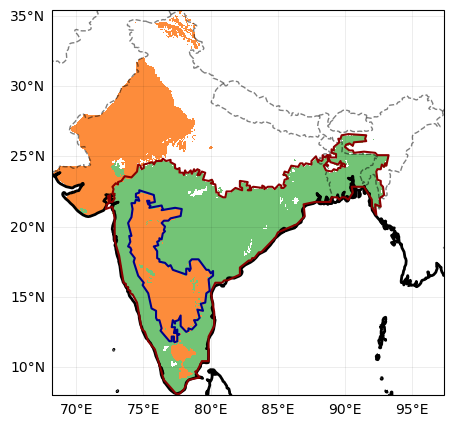

In [81]:
fig, ax = plt.subplots(dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (6,5))
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Greens", add_colorbar = False) for r in range(1,4)]
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Oranges", add_colorbar = False) for r in range(4,8)]

ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)    
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

gpd.read_file("sf_indiabangladesh-tropical-exterior").boundary.plot(ax = ax, color = "darkred")
gpd.read_file("sf_indiabangladesh-tropical-hole").boundary.plot(ax = ax, color = "darkblue")

---
## **CORDEX**

### **India & Bangladesh**

_RegCM4-4 has no land-sea mask_

In [12]:
sf_ext = gpd.read_file("sf_indiabangladesh-tropical-exterior")
sf_int = gpd.read_file("sf_indiabangladesh-tropical-hole")

fl = glob.glob("../synda/data/CORDEX/WAS-44/*/*/*/day/")
for fpath in fl:
    
    tasmax_fl = sorted(glob.glob(fpath+"tasmax/*"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+tasmax_fl[0][-20:-12]+"-", tasmax_fl[-1].split("/")[-1])
    print(str(fl.index(fpath)+1).rjust(2, "0")+"/"+str(len(fl))+" "+new_fnm)
    if len(glob.glob("cordex/EA-hw_tx4x-ib-ext_"+new_fnm.split("_")[1]+"_"+cordex_model(new_fnm)+".dat")) > 0: continue
    
    # load max temps
    da = convert_units_to(xr.open_mfdataset(tasmax_fl).tasmax, "degC")
    
    if "rlon" in da.dims:
        x_dim, y_dim = ["rlon", "rlat"]
    elif "x" in da.dims:
        x_dim, y_dim = ["x", "y"]
    
    # get area
    sp_mask = np.logical_and(np.logical_and(da.lat > 5, da.lat < 60), np.logical_and(da.lon > 60, da.lon < 150))
    sp_mask = sp_mask.where(sp_mask == 1).dropna(x_dim, "all").dropna(y_dim, "all")
    
    # trim data to area required
    da = da.sel({x_dim : sp_mask[x_dim], y_dim : sp_mask[y_dim]})
    
    # spatial pattern over larger rectangular region (obs period only)
    sp = da.sel(time = slice("1980", "2022")).groupby("time.month")[4].mean("time").reset_coords(drop = True)
    sp.to_netcdf("cordex/sp-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # load land-sea mask
    lsm_fnm = glob.glob(re.sub("day/", "fx/sftlf/*.nc", re.sub("r[0-9]+i1p1", "*", fpath)))
    if len(lsm_fnm) > 0:
        lsm = xr.open_dataset(lsm_fnm[0]).sftlf
        lsm = xr.ones_like(lsm).where(lsm >= 0.5).sel({x_dim : sp_mask[x_dim], y_dim : sp_mask[y_dim]})
        da = da.where(lsm == 1)
    else:
        print("No LSM: "+fpath)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # create regionmasks
    rm_ext = regionmask.mask_3D_geopandas(sf_ext, da.lon, da.lat, drop = False).squeeze(drop = True)
    rm_int = regionmask.mask_3D_geopandas(sf_int, da.lon, da.lat, drop = False).squeeze(drop = True)
    rm_tropical = np.logical_xor(rm_ext, rm_int)
    
    # seasonal cycle over the study region (obs period only)
    sc_ext = da.where(rm_ext == 1).mean([x_dim, y_dim]).sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc_ext.to_netcdf("cordex/sc-ib-ext-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    sc_trop = da.where(rm_tropical == 1).mean([x_dim, y_dim]).sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc_trop.to_netcdf("cordex/sc-ib-trop-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # time series: April maximum of 4-day rolling average of tasmax
    tx4x_ext = da.where(rm_ext == 1).mean([x_dim, y_dim]).rolling(time = 4).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
    tx4x_trop = da.where(rm_tropical == 1).mean([x_dim, y_dim]).rolling(time = 4).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    csv_fnm = "cordex/EA-hw_tx4x-ib-ext_"+new_fnm.split("_")[1]+"_"+cordex_model(new_fnm)+".dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
        
    # create  header lines
    str1 = "# contact :: CORDEX "+cordex_model(new_fnm)+" tx4x-apr in India/Bangladesh - East Asia spring heatwaves 2023, c.barnes22@imperial.ac.uk"
    str2 = "# tx4x-apr [degC] annual maximum of 4-day rolling tasmax during April in India/Bangladesh"+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tx4x-apr"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    tx4x_ext.assign_coords(time = tx4x_ext.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    csv_fnm = re.sub("-ext", "-trop", csv_fnm)
    
    str2 = re.sub("in India", "in tropical India", str2)
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    tx4x_trop.assign_coords(time = tx4x_ext.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Laos & Thailand**

In [2]:
for fpath in glob.glob("../synda/data/CORDEX/SEA-22/*/*/*/day/"):
    
    tasmax_fl = sorted(glob.glob(fpath+"tasmax/*"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+tasmax_fl[0][-20:-12]+"-", tasmax_fl[-1].split("/")[-1])
    print(new_fnm)
    if len(glob.glob("cordex/EA-hw_tx4x-tl_"+new_fnm.split("_")[1]+"_"+cordex_model(new_fnm)+".dat")) > 0: continue
    
    # load max temps
    da = convert_units_to(xr.open_mfdataset(tasmax_fl).tasmax, "degC")
    
    if "rlon" in da.dims:
        x_dim, y_dim = ["rlon", "rlat"]
    elif "x" in da.dims:
        x_dim, y_dim = ["x", "y"]
    
    # get area
    sp_mask = np.logical_and(np.logical_and(da.lat > 5, da.lat < 60), np.logical_and(da.lon > 60, da.lon < 150))
    sp_mask = sp_mask.where(sp_mask == 1).dropna(x_dim, "all").dropna(y_dim, "all")
    
    # trim data to area required
    da = da.sel({x_dim : sp_mask[x_dim], y_dim : sp_mask[y_dim]})
    
    # spatial pattern over larger rectangular region (obs period only)
    sp = da.sel(time = slice("1980", "2022")).groupby("time.month")[4].mean("time").reset_coords(drop = True)
    sp.to_netcdf("cordex/sp-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # load land-sea mask
    lsm_fnm = glob.glob(re.sub("day/", "fx/sftlf/*.nc", re.sub("r[0-9]+i1p1", "*", fpath)))
    if len(lsm_fnm) > 0:
        lsm = xr.open_dataset(lsm_fnm[0]).sftlf
        lsm = xr.ones_like(lsm).where(lsm >= 0.5).sel({x_dim : sp_mask[x_dim], y_dim : sp_mask[y_dim]})
        da = da.where(lsm == 1)
    else:
        print("No LSM: "+fpath)

    # create regionmasks
    rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat).sel(region = [91,92]).sum("region")

    # seasonal cycle over the study region (obs period only)
    sc = da.where(rm == 1).mean([x_dim, y_dim]).sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc.to_netcdf("cordex/sc-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # time series: April maximum of 4-day rolling average of tasmax
    tx4x = da.where(rm == 1).mean([x_dim, y_dim]).rolling(time = 4).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    csv_fnm = "cordex/EA-hw_tx4x-tl_"+new_fnm.split("_")[1]+"_"+cordex_model(new_fnm)+".dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
        
    # create  header lines
    str1 = "# contact :: CORDEX "+cordex_model(new_fnm)+" tx4x-apr in Thailand & Laos - East Asia spring heatwaves 2023, c.barnes22@imperial.ac.uk"
    str2 = "# tx4x-apr [degC] annual maximum of 4-day rolling tasmax during April in Thailand & Laos"+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tx4x-apr"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    tx4x.assign_coords(time = tx4x.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

tasmax_SEA-22_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_SMHI-RCA4_v1_day_19510101-21001231.nc
tasmax_SEA-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_day_19700101-21001231.nc
tasmax_SEA-22_MPI-M-MPI-ESM-MR_rcp85_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20991231.nc
tasmax_SEA-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v1_day_19510101-20991230.nc
tasmax_SEA-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_day_19700101-20991230.nc
tasmax_SEA-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20991230.nc
tasmax_SEA-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_day_19700101-21001231.nc
tasmax_SEA-22_NCC-NorESM1-M_rcp85_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20991231.nc
